In [188]:
from plotnine import *
import pandas
from solarized import *
import tikzplotlib
pandas.options.display.max_rows=10

In [189]:
# 1.{5end_to_end} tpch 1,2,3,4,5 with scale 1, 10
# 2 {5module4} and 3. module4 | also {5module4mem} and {5module4net}
# 3.{5tpchmodin} tpch 1, 4, 5 with modin on scale 10
# 4.{5micro_scales} micros with scale 1, 10 | also {5micro_traffic}
# 5.{5micro_net} micro join, selection with net=wan and scale 1

In [190]:
factors= ['wflow', 'optimizer', 'net', 'scale']
df=pandas.read_feather('specific-reports/5module4.feather')
df.rename(columns={"db_time":"transfer_time"}, inplace=True)
df.columns

Index(['bytes_memory', 'cpu_percent', 'bytes_sent', 'bytes_recv',
       'snapshot_idx', 'proc_time', 'exitcode', 'transfer_time',
       'shared_wall_time', 'wflow', 'optimizer', 'scale', 'net'],
      dtype='object')

In [191]:
df['shared_wall_time'].value_counts()

228.338791    2932
75.159439      944
Name: shared_wall_time, dtype: int64

# CHECK

In [192]:
df['exitcode'].value_counts()

0    3876
Name: exitcode, dtype: int64

In [193]:
df.query("exitcode == 1")['wflow'].unique()

array([], dtype=object)

# PREPROCESS

In [194]:
overview = df.groupby(by=factors).first().reset_index()
overview.columns

Index(['wflow', 'optimizer', 'net', 'scale', 'bytes_memory', 'cpu_percent',
       'bytes_sent', 'bytes_recv', 'snapshot_idx', 'proc_time', 'exitcode',
       'transfer_time', 'shared_wall_time'],
      dtype='object')

In [195]:

overview["py_time"] = overview["shared_wall_time"] - overview["transfer_time"]

In [196]:
module4 = overview[["wflow", "optimizer", "py_time", "transfer_time"]]

In [197]:
module4

,wflow,optimizer,py_time,transfer_time
0,module4.py,base,46.504822,181.833969
1,module4.py,optimized,0.000023,75.159416


# {5module4}

In [220]:
plot_df = module4.melt(id_vars=["wflow", "optimizer"], value_vars=["py_time", "transfer_time"],
                    value_name='measurement', var_name='var')


In [221]:
# I recorded the ml time separately
ml_df = pandas.DataFrame({"wflow":["module4.py"]*2, "optimizer":["base", "optimized"], "var":["ml_time"]*2, "measurement":[56.4823000]*2})
plot_df = plot_df.append(ml_df)

In [222]:
plot = (
        ggplot(plot_df, aes('optimizer', y='measurement', fill='var'))
        + geom_col(width=0.3)
        #+ scale_fill_manual(values=cdict) 
        + facet_wrap('wflow', scales='free')
        + xlab("Optimization Method")
        + ylab("Time (in sec.)")
        + theme(
              #   figure_size=(5, 2.5)
              #  ,subplots_adjust={'hspace': 1, 'wspace': 0.25}
               )
    )

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5module4.png
E:\ssdapps\anaconda\lib\site-packages\tikzplotlib\_save.py:390: UserWarning: tikzplotlib: Don't know how to handle object <class 'matplotlib.offsetbox.AnchoredOffsetbox'>.


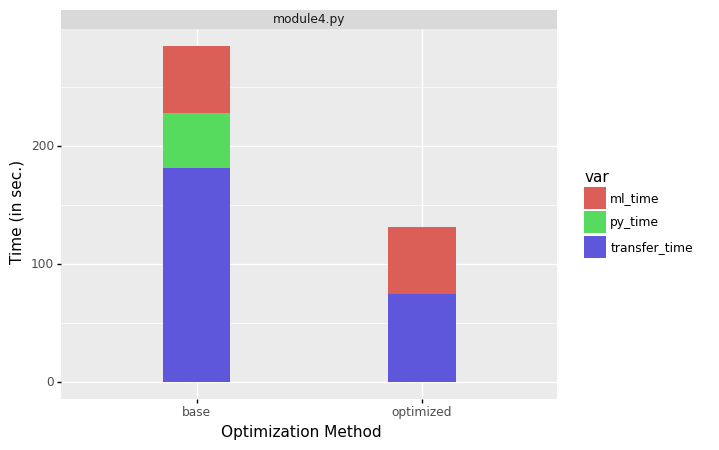

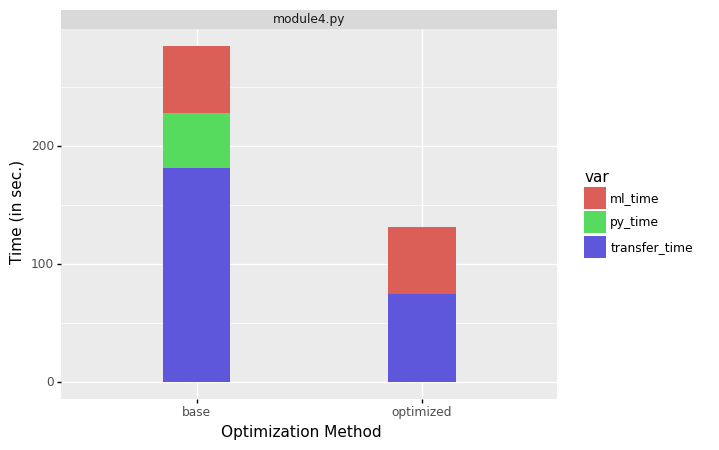

<ggplot: (107513200535)>

In [223]:
plot.save("specific-plots/5module4.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5module4.tikz', figure=matplot)
display(plot)

a ...\% total time decrease when the bulk of the data preprocessing is performed near the data source. In addition to eliminating most of the data preprocessing inside the procedural runtime, we observe a ..\% decrease in the data transfer time


# {5module4net}

In [224]:
overview['gb_net'] = overview['bytes_recv']/10**9

In [225]:
plot_df = overview[["wflow", "optimizer", "gb_net"]]

In [226]:
plot = (
    ggplot(plot_df, aes('optimizer', y='gb_net'))
    + geom_col(width=0.3)
    #+ scale_fill_manual(values=cdict)
    + xlab("Optimization Method")
    + ylab("Network Transfer (in GB)")
    + facet_wrap('wflow', scales='free')
    #+ coord_flip()
    + theme(
            # figure_size=(5, 2.5)
            #,subplots_adjust={'hspace': 1, 'wspace': 0.25}
           )
)

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5module4net.png


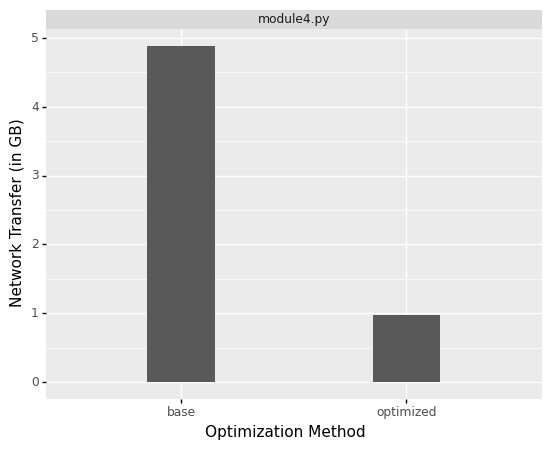

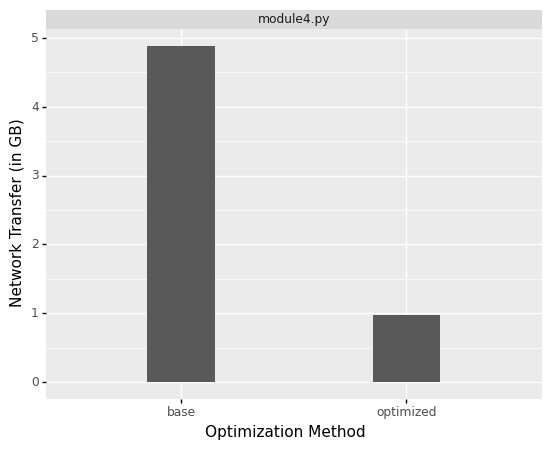

<ggplot: (107510844859)>

In [227]:
plot.save("specific-plots/5module4net.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5module4net.tikz', figure=matplot)
display(plot)

 confirm that the top memory consumption decreased by ..\% and the  bandwidth requirements sinked by ..\% because of the operation push down

# {5module4mem}

In [228]:
df["db_ratio"] = df["transfer_time"] / df["shared_wall_time"]

In [229]:
df['gb_memory'] = df['bytes_memory']/10**9

In [230]:
plot_df = df[["db_ratio", "wflow", "optimizer", "gb_memory", "snapshot_idx"]]

In [235]:
plot_df['color']=C_BLUE
dummy_df=plot_df.copy()
dummy_df['color'] = C_GREEN
plot = (
ggplot(plot_df, aes('snapshot_idx', y='gb_memory'))
#+ geom_area(aes(fill='color'))
+ geom_histogram(aes(fill='color'))
+ geom_rect(aes(xmax='db_ratio', fill='color'), dummy_df, xmin=0,ymin=0,ymax=100,
           alpha=0.2)
+ facet_grid('optimizer ~ wflow')
+ theme(figure_size=(8, 2.5))
#+ labs(y=None)
+ scale_fill_identity(name = 'Area colors', guide = 'legend',labels = ('Global Memory Consumption in %', 'Execution inside the RDBMS')) 
# + scale_colour_manual(name = 'the colour', 
#     values ={'black':'white','red':'blue'}, labels = ('c2','c1'))
)

<ipython-input-235-2b48fc01e6d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [236]:
plot.save("specific-plots/5module4mem.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5module4mem.tikz', figure=matplot)
display(plot)

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 8 x 2.5 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5module4mem.png


PlotnineError: 'stat_bin() must not be used with a y aesthetic.'